TSLA expected annual return (arima_forecast): 0.00%
Max Sharpe Portfolio:


,ret,vol,sharpe,w_TSLA,w_BND,w_SPY
2387,0.152299,0.189916,0.696619,0.000585,0.023896,0.975519



Min Volatility Portfolio:


,ret,vol,sharpe,w_TSLA,w_BND,w_SPY
6705,0.022776,0.058859,0.04716,0.000689,0.955537,0.043774


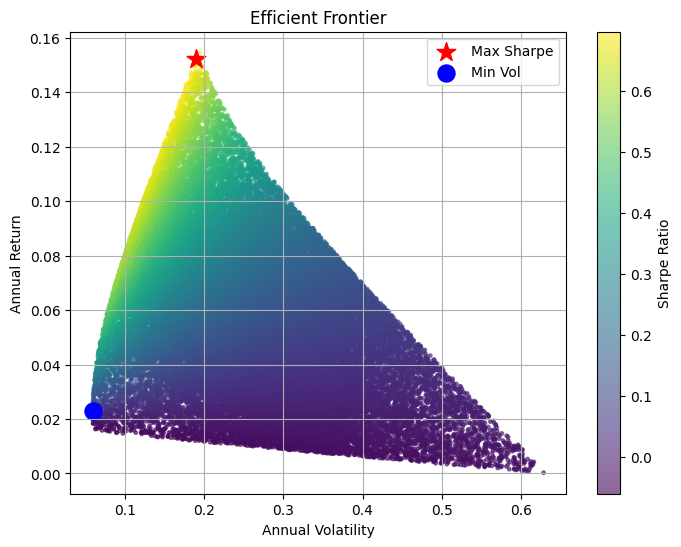


=== Recommended Portfolio ===
Choice: Max Sharpe
Weights -> TSLA: 0.001, BND: 0.024, SPY: 0.976
Expected annual return: 15.23%
Annual volatility: 18.99%
Sharpe Ratio: 0.697


In [3]:
# Task 4: Portfolio Optimization using Forecasted TSLA Return

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ---------------- Config ----------------
USE_YFINANCE = True   # True = download via yfinance, False = use CSVs
START_DATE = '2018-01-01'
END_DATE = None  # None = today
TSLA_CSV = '/content/drive/MyDrive/week11/data/raw/TSLA.csv'
BND_CSV = '/content/drive/MyDrive/week11/data/raw/BND.csv'
SPY_CSV = '/content/drive/MyDrive/week11/data/raw/SPY.csv'
TSLA_FORECAST_PATH = ''  # CSV from Task 3 forecast, optional
FORECAST_HORIZON_DAYS = 252  # ~12 months
N_PORTFOLIOS = 50000
RISK_FREE_RATE = 0.02  # annual

# ---------------- Imports ----------------
try:
    import yfinance as yf
except ImportError:
    yf = None
try:
    from pmdarima import auto_arima
    AUTO_ARIMA = True
except ImportError:
    AUTO_ARIMA = False
from statsmodels.tsa.arima.model import ARIMA as SM_ARIMA

# ---------------- Load Data ----------------
def load_prices(ticker=None, csv_path=None, start=None, end=None):
    if csv_path and Path(csv_path).exists():
        df = pd.read_csv(csv_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date').sort_index()
        if 'Close' in df.columns:
            return df['Close']
        elif 'Adj Close' in df.columns:
            return df['Adj Close']
        else:
            raise ValueError('CSV must include Close or Adj Close')
    else:
        if yf is None:
            raise RuntimeError('yfinance not available and CSV not found')
        df = yf.download(ticker, start=start, end=end, progress=False)
        return df['Close']

end_date = END_DATE if END_DATE else datetime.today().strftime('%Y-%m-%d')
if USE_YFINANCE:
    tsla = load_prices('TSLA', start=START_DATE, end=end_date)
    bnd  = load_prices('BND',  start=START_DATE, end=end_date)
    spy  = load_prices('SPY',  start=START_DATE, end=end_date)
else:
    tsla = load_prices(csv_path=TSLA_CSV)
    bnd  = load_prices(csv_path=BND_CSV)
    spy  = load_prices(csv_path=SPY_CSV)

prices = pd.concat([tsla, bnd, spy], axis=1, keys=['TSLA','BND','SPY']).dropna()
prices = prices.asfreq('B').ffill().dropna()

# ---------------- TSLA Expected Return ----------------
last_price = prices['TSLA'].iloc[-1]

if TSLA_FORECAST_PATH and Path(TSLA_FORECAST_PATH).exists():
    fc_df = pd.read_csv(TSLA_FORECAST_PATH)
    mean_vals = fc_df['mean'].values[:FORECAST_HORIZON_DAYS]
    daily_rets = np.diff(mean_vals) / (mean_vals[:-1] + 1e-9)
    exp_daily_return_tsla = np.mean(daily_rets)
    exp_annual_return_tsla = (1 + exp_daily_return_tsla)**252 - 1
    source = 'provided_forecast_csv'
else:
    series = prices['TSLA'].astype(float)
    h = FORECAST_HORIZON_DAYS
    try:
        if AUTO_ARIMA:
            arima_model = auto_arima(series, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
            fc = arima_model.predict(n_periods=h)
        else:
            fit = SM_ARIMA(series, order=(1,1,1)).fit()
            fc = fit.forecast(steps=h)
        daily_rets = np.diff(fc) / (fc[:-1] + 1e-9)
        exp_daily_return_tsla = np.mean(daily_rets)
        exp_annual_return_tsla = (1 + exp_daily_return_tsla)**252 - 1
        source = 'arima_forecast'
    except Exception:
        hist_daily = prices['TSLA'].pct_change().dropna()
        exp_daily_return_tsla = hist_daily.mean()
        exp_annual_return_tsla = (1 + exp_daily_return_tsla)**252 - 1
        source = 'historical_mean_fallback'

print(f'TSLA expected annual return ({source}): {exp_annual_return_tsla:.2%}')

# ---------------- Historical Returns & Covariance ----------------
rets = prices.pct_change().dropna()
mean_daily_bnd = rets['BND'].mean()
mean_daily_spy = rets['SPY'].mean()
exp_annual_bnd = (1 + mean_daily_bnd)**252 - 1
exp_annual_spy = (1 + mean_daily_spy)**252 - 1

exp_returns = np.array([exp_annual_return_tsla, exp_annual_bnd.iloc[0], exp_annual_spy.iloc[0]])
cov_annual = rets[['TSLA','BND','SPY']].cov() * 252

# ---------------- Portfolio Simulation ----------------
n = 3
results = np.zeros((N_PORTFOLIOS, 6))  # ret, vol, sharpe, w_TSLA, w_BND, w_SPY
for i in range(N_PORTFOLIOS):
    weights = np.random.random(n)
    weights /= np.sum(weights)
    port_ret = np.dot(weights, exp_returns)
    port_vol = np.sqrt(weights.T @ cov_annual.values @ weights)
    sharpe = (port_ret - RISK_FREE_RATE) / (port_vol + 1e-9)
    results[i,:] = [port_ret, port_vol, sharpe, *weights]

res_df = pd.DataFrame(results, columns=['ret','vol','sharpe','w_TSLA','w_BND','w_SPY'])
max_sharpe = res_df.loc[res_df['sharpe'].idxmax()]
min_vol = res_df.loc[res_df['vol'].idxmin()]

print("Max Sharpe Portfolio:")
display(max_sharpe.to_frame().T)
print("\nMin Volatility Portfolio:")
display(min_vol.to_frame().T)

# ---------------- Efficient Frontier Plot ----------------
plt.figure(figsize=(8,6))
plt.scatter(res_df['vol'], res_df['ret'], c=res_df['sharpe'], cmap='viridis', s=6, alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe['vol'], max_sharpe['ret'], color='r', marker='*', s=200, label='Max Sharpe')
plt.scatter(min_vol['vol'], min_vol['ret'], color='b', marker='o', s=150, label='Min Vol')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

# ---------------- Recommendation ----------------
choice = 'Max Sharpe'
recommended = max_sharpe if choice == 'Max Sharpe' else min_vol
print("\n=== Recommended Portfolio ===")
print(f"Choice: {choice}")
print(f"Weights -> TSLA: {recommended['w_TSLA']:.3f}, BND: {recommended['w_BND']:.3f}, SPY: {recommended['w_SPY']:.3f}")
print(f"Expected annual return: {recommended['ret']:.2%}")
print(f"Annual volatility: {recommended['vol']:.2%}")
print(f"Sharpe Ratio: {recommended['sharpe']:.3f}")